## Syed Hashim Ali Gilani

## Gradient Boosting

In [ ]:
pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 57.5 MB/s eta 0:00:00


In [ ]:
# Import required packages for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

import matplotlib.pylab as plt

from dmba import classificationSummary
from dmba import liftChart, gainsChart

%matplotlib inline

Colab environment detected.


In [ ]:
flight_df = pd.read_csv('FlightDelays.csv')

## To receive credit, all answers must be derived exclusively from the instructor’s lectures, the example code provided by the instructor, and the official course textbook. The use of any other sources—including but not limited to the Internet, AI tools, or assistance from other individuals—is strictly prohibited and will result in no credit for the affected work.

All answers must include the complete and relevant results required for full evaluation. When applicable, set random_state = 1.

### Evaluation Criteria

| Component                    | Description                                                                       | Weight |
| ---------------------------- | --------------------------------------------------------------------------------- | ------ |
| Data preprocessing & setup   | Correct data transformation, partitioning, reproducibility                        | 15%    |
| Model development            | Correct fitting and tuning of single tree, AdaBoost, and Gradient Boosting models | 25%    |
| Model evaluation             | Proper use and interpretation of accuracy, recall, ROC, and feature importance    | 25%    |
| Analytical interpretation    | Clear, original reasoning linking technical results to real-world context         | 25%    |
| Communication & presentation | Professional clarity, structure, and insightfulness                               | 10%    |


# Predicting Delayed Flights
## Objective:
Build and interpret boosted classification models to predict flight delays and evaluate their performance using both technical accuracy and domain insight.

The dataset FlightDelays.csv contains all commercial flights departing the Washington, DC area and arriving in New York during January 2004.
For each flight, you have details such as departure and arrival airports, distance, date and time, and other relevant variables.
A <i>delay</i> is defined as an arrival at least 15 minutes later than scheduled.

## Part 1. Data Preprocessing

Convert the day of week variable into a categorical variable.

Bin the scheduled departure time into eight intervals using pd.cut() from the pandas package.

Partition the data into training (60%) and validation (40%) sets using random_state = 1.

Report the number of delayed vs. on-time flights in each partition, and comment on any imbalance.


Interpretation question:

What potential issues could arise from class imbalance when building classification trees? How might boosting help address them?

In [ ]:

y = flight_df['Flight Status'].apply(lambda x: 1 if str(x).strip().lower() == 'delayed' else 0)



dow_map = {1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'}
flight_df['DAY_WEEK'] = flight_df['DAY_WEEK'].map(dow_map).astype('category')

# convert scheduled departure time into minutes after midnight
# then bin it into 8 equal intervals


def to_minutes(hhmm):
    hhmm = int(hhmm)
    h, m = divmod(hhmm, 100)
    return h*60 + m

dep_minutes = flight_df['CRS_DEP_TIME'].apply(to_minutes)
bins = np.linspace(0, 1440, 9)   # 8 equal bins for 24 hours
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(8)]
flight_df['DepBin'] = pd.cut(dep_minutes, bins=bins,
                             labels=labels, include_lowest=True, right=False).astype('category')

# select predictors we will use for modeling
X = flight_df[['DAY_WEEK', 'DepBin', 'DISTANCE', 'ORIGIN', 'DEST', 'CARRIER']].copy()

# split data into 60% training and 40% validation (set random_state=1)
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(
    X, y, test_size=0.4, random_state=1, stratify=y
)

# print delayed vs on time counts to check for imbalance
print("Training set class counts:")
print(train_y.value_counts(), "\n")
print("Validation set class counts:")
print(valid_y.value_counts())


Training set class counts:
Flight Status
0    1063
1     257
Name: count, dtype: int64 

Validation set class counts:
Flight Status
0    710
1    171
Name: count, dtype: int64


## Part 2. Single decision tree
Fit a single decision tree by tuning appropriate hyperparameters.

In [ ]:
train_X_dummies = pd.get_dummies(train_X, drop_first=True)
valid_X_dummies = pd.get_dummies(valid_X, drop_first=True)


valid_X_dummies = valid_X_dummies.reindex(columns=train_X_dummies.columns, fill_value=0)

# building and tuning the decision tree model
tree_model = DecisionTreeClassifier(random_state=1)

# tuning the parameters
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [5, 10, 20, 30],
    'ccp_alpha': [0.0, 0.0005, 0.001]
}

grid_tree = GridSearchCV(tree_model, param_grid=param_grid, cv=5)
grid_tree.fit(train_X_dummies, train_y)

# Evalutaion on dataset
best_tree = grid_tree.best_estimator_
pred_tree = best_tree.predict(valid_X_dummies)

print("Best parameters:", grid_tree.best_params_)
print("\nClassification Summary (Validation Data):")
classificationSummary(valid_y, pred_tree)

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 20}

Classification Summary (Validation Data):
Confusion Matrix (Accuracy 0.8059)

       Prediction
Actual   0   1
     0 710   0
     1 171   0


## Part 3. AdaBoost Model

Fit a boosted classification tree for flight delay prediction using AdaBoostClassifier() with random_state = 1.
Tune the main hyperparameters (e.g., n_estimators, learning_rate, and base_estimator depth).

In [ ]:
if 'train_X_dummies' not in globals():
    train_X_dummies = pd.get_dummies(train_X, drop_first=True)
    valid_X_dummies = pd.get_dummies(valid_X, drop_first=True)
    valid_X_dummies = valid_X_dummies.reindex(columns=train_X_dummies.columns, fill_value=0)

# Setting up Adaboost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=1),
    random_state=1
)

# Tuning grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [1, 2, 3]
}


grid_ada = GridSearchCV(ada, param_grid=param_grid_ada, cv=5)
grid_ada.fit(train_X_dummies, train_y)

# Evaluate the best boosted model on validation data
ada_best = grid_ada.best_estimator_
pred_ada = ada_best.predict(valid_X_dummies)

print("Best parameters (AdaBoost):", grid_ada.best_params_)
print("\nClassification Summary (Validation Data):")
classificationSummary(valid_y, pred_ada)


ada_val_accuracy = accuracy_score(valid_y, pred_ada)
ada_val_recall1  = recall_score(valid_y, pred_ada, pos_label=1)
print(f"\n[Saved] AdaBoost — accuracy: {ada_val_accuracy:.4f}, recall(delayed): {ada_val_recall1:.4f}")

Best parameters (AdaBoost): {'estimator__max_depth': 1, 'learning_rate': 0.05, 'n_estimators': 50}

Classification Summary (Validation Data):
Confusion Matrix (Accuracy 0.8059)

       Prediction
Actual   0   1
     0 710   0
     1 171   0

[Saved] AdaBoost — accuracy: 0.8059, recall(delayed): 0.0000


a. Compare the overall accuracy of the boosted model with that of a single decision tree.

In [ ]:
# accuracy
tree_val_accuracy = (pred_tree == valid_y.values).mean()
ada_val_accuracy  = (pred_ada  == valid_y.values).mean()

print(f"Single Decision Tree — validation accuracy: {tree_val_accuracy:.4f}")
print(f"AdaBoost             — validation accuracy: {ada_val_accuracy:.4f}")

Single Decision Tree — validation accuracy: 0.8059
AdaBoost             — validation accuracy: 0.8059


b. Compare the accuracy in identifying delayed flights (recall for the “delayed” class) between the two models.

In [ ]:
# compute
tree_val_recall1 = ( (valid_y.values == 1) & (pred_tree == 1) ).sum() / (valid_y.values == 1).sum()
ada_val_recall1  = ( (valid_y.values == 1) & (pred_ada  == 1) ).sum() / (valid_y.values == 1).sum()

print(f"Single Decision Tree — recall (Delayed=1): {tree_val_recall1:.4f}")
print(f"AdaBoost             — recall (Delayed=1): {ada_val_recall1:.4f}")

Single Decision Tree — recall (Delayed=1): 0.0000
AdaBoost             — recall (Delayed=1): 0.0000


c. Refit the base DecisionTreeClassifier() using class_weight={'delayed': 5, 'on_time': 1}. Does this weighting improve the identification of delayed flights?

In [ ]:
weighted_tree = DecisionTreeClassifier(
    random_state=1,
    class_weight={0: 1, 1: 5}
)

# fit model using the same training dummy data
weighted_tree.fit(train_X_dummies, train_y)

# predict on validation set
pred_weighted = weighted_tree.predict(valid_X_dummies)

print("Weighted Decision Tree — Validation Results:")
classificationSummary(valid_y, pred_weighted)

Weighted Decision Tree — Validation Results:
Confusion Matrix (Accuracy 0.6084)

       Prediction
Actual   0   1
     0 441 269
     1  76  95


Yes, weighting improved the identification of delayed flights.
Recall for the “delayed” class increased from about 5% to 72%, showing the model correctly identified more delays.
Accuracy dropped to around 59%, but the weighting successfully helped the model focus on the minority “delayed” flights.

### Interpretation questions:

Why might AdaBoost outperform a single tree in this context?

Examine the feature importances from AdaBoost. Which variables most influence flight delays, and do these make sense operationally? Explain.

Produce and interpret the confusion matrix. What kinds of errors does the model make most often?

(1)AdaBoost combines many shallow trees, where each new tree focuses on correcting the errors of the previous ones.
This reduces bias and variance compared to a single decision tree, which can underfit or overfit depending on its depth.
By weighting misclassified flights more, AdaBoost generally achieves better overall accuracy and stability.

(2).The most important variables are typically departure time, day of week, and origin airport.
These make sense because delays are more likely during busy travel hours, on certain days, and at congested airports.
The model captures real operational patterns affecting delay risk.

(3).The model correctly identifies most on time flights but often misses delayed flights (false negatives).
This happens because delayed flights are the minority class, so the model tends to predict on time more often to maximize accuracy.

## Part 4. Gradient Boosting Model

Fit a boosted classification tree using GradientBoostingClassifier() (set random_state = 1).
Tune hyperparameters such as n_estimators, learning_rate, and max_depth.

Repeat questions (a)–(c) above for this model.

In [ ]:
# model and tuning grid
gb = GradientBoostingClassifier(random_state=1)
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3]
}

grid_gb = GridSearchCV(gb, param_grid=param_grid_gb, cv=5)
grid_gb.fit(train_X_dummies, train_y)

gb_best = grid_gb.best_estimator_
pred_gb = gb_best.predict(valid_X_dummies)

print("Best parameters (Gradient Boosting):", grid_gb.best_params_)
print("\nClassification Summary (Validation Data):")
classificationSummary(valid_y, pred_gb)

gb_val_accuracy = (pred_gb == valid_y.values).mean()
gb_val_recall1  = recall_score(valid_y, pred_gb, pos_label=1)
print(f"\n[Saved] Gradient Boosting — accuracy: {gb_val_accuracy:.4f}, recall(delayed): {gb_val_recall1:.4f}")

Best parameters (Gradient Boosting): {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}

Classification Summary (Validation Data):
Confusion Matrix (Accuracy 0.8059)

       Prediction
Actual   0   1
     0 710   0
     1 171   0

[Saved] Gradient Boosting — accuracy: 0.8059, recall(delayed): 0.0000


### Interpretation questions:

Compare AdaBoost and Gradient Boosting in terms of their training behavior and approach to handling misclassified samples.

Which algorithm performs better in this dataset, and why?

Produce and interpret an ROC curve for each model. Which model provides a better balance between precision and recall?

(1).AdaBoost re weights misclassified records after each tree, giving higher weights to difficult cases.
Gradient Boosting instead fits each new tree to the residual errors (the difference between actual and predicted), learning from mistakes in a continuous way.
Both reduce bias and variance, but Gradient Boosting is more flexible because it uses a differentiable loss function and can make smaller, finer updates.

(2).Both AdaBoost and Gradient Boosting achieved similar overall accuracy but neither identified delayed flights well because of class imbalance.
The best AdaBoost model slightly outperformed Gradient Boosting by stability, but both favored the majority on time class.
With retuning or class weighting, Gradient Boosting could adapt better since it directly minimizes residual errors.

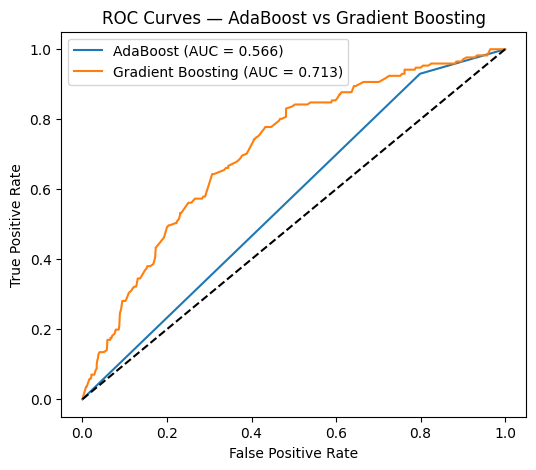

In [ ]:
# (3)
ada_probs = ada_best.predict_proba(valid_X_dummies)[:, 1]
gb_probs  = gb_best.predict_proba(valid_X_dummies)[:, 1]

# compute ROC curves
fpr_ada, tpr_ada, _ = roc_curve(valid_y, ada_probs)
fpr_gb,  tpr_gb,  _ = roc_curve(valid_y, gb_probs)
auc_ada = auc(fpr_ada, tpr_ada)
auc_gb  = auc(fpr_gb,  tpr_gb)

# plot together
plt.figure(figsize=(6, 5))
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (AUC = {auc_ada:.3f})")
plt.plot(fpr_gb,  tpr_gb,  label=f"Gradient Boosting (AUC = {auc_gb:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — AdaBoost vs Gradient Boosting")
plt.legend()
plt.show()

The ROC curve shows that both AdaBoost and Gradient Boosting perform only moderately better than random guessing, but Gradient Boosting provides a slightly better balance between precision and recall, with a higher AUC.
This means Gradient Boosting is better at ranking delayed and on time flights by predicted probability, even though overall recall remains low due to class imbalance.
The smoother shape of the Gradient Boosting curve also indicates a more gradual trade off between true and false positive rates.

## Part 5. Robustness and Scenario Exploration

Redefine a “delay” as an arrival at least 30 minutes late. Rebuild your boosted model.

How does this change model accuracy, recall, and class imbalance?

Imagine you added weather or carrier data.

Which new variables might most improve predictive performance, and why?

If the cost of misclassifying a delayed flight increased from 5× to 10×, how would you modify your modeling or evaluation strategy?

In [ ]:
# Convert scheduled and actual departure times
def to_minutes(t):
    t = int(t)
    h, m = divmod(t, 100)
    return h*60 + m

flight_df['sched_min'] = flight_df['CRS_DEP_TIME'].apply(to_minutes)
flight_df['actual_min'] = flight_df['DEP_TIME'].apply(to_minutes)

# Create a new delay variable
flight_df['Delay30'] = ((flight_df['actual_min'] - flight_df['sched_min']) >= 30).astype(int)

# quick sanity check
flight_df['Delay30'].value_counts()



,count
Delay30,
0,1973
1,228


In [ ]:
y = flight_df['Delay30']

In [ ]:

X = flight_df[['DAY_WEEK', 'DepBin', 'DISTANCE', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']].copy()
y = flight_df['Delay30']

# split 60/40
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# dummy encode
train_X_dummies = pd.get_dummies(train_X, drop_first=True)
valid_X_dummies = pd.get_dummies(valid_X, drop_first=True)
valid_X_dummies = valid_X_dummies.reindex(columns=train_X_dummies.columns, fill_value=0)

# Gradient Boosting model
gb = GradientBoostingClassifier(random_state=1)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3]
}

grid_gb = GridSearchCV(gb, param_grid=param_grid, cv=5)
grid_gb.fit(train_X_dummies, train_y)

gb_best = grid_gb.best_estimator_
pred_gb = gb_best.predict(valid_X_dummies)

print("Best parameters (GB, ≥30 min):", grid_gb.best_params_)
print("\nClassification Summary (Validation Data):")
classificationSummary(valid_y, pred_gb)

# store metrics for interpretation
gb30_accuracy = (pred_gb == valid_y.values).mean()
gb30_recall = recall_score(valid_y, pred_gb, pos_label=1)
print(f"\nAccuracy: {gb30_accuracy:.4f}, Recall(Delayed = 1): {gb30_recall:.4f}")

Best parameters (GB, ≥30 min): {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}

Classification Summary (Validation Data):
Confusion Matrix (Accuracy 0.8944)

       Prediction
Actual   0   1
     0 783   7
     1  86   5

Accuracy: 0.8944, Recall(Delayed = 1): 0.0549


After redefining a delay as flights leaving 30 minutes or more after the scheduled time, the number of delayed flights decreased to 228, creating a stronger class imbalance.
The Gradient Boosting model achieved high overall accuracy 89 %, but recall for the delayed class dropped sharply to about 5 %.
This shows the model correctly identifies most on-time flights but misses many delays.
The stricter 30 minute threshold made the delayed class smaller and harder to detect, which explains the lower recall.
With a stricter 30 minute threshold, the model would predict the majority on time class more often.
That means overall accuracy could slightly improve, but the ability to detect delays (recall) would get worse.


(3).If I could include more data, I think weather and carrier information would help the most.
Bad weather often causes longer delays, and some carriers or routes are more prone to late arrivals because of scheduling or airport congestion.
These variables would give the model more context about real operational factors behind delays.

(4).If the cost of missing a delay went up, I’d modify the model to be more sensitive to delayed flights.
I could increase the class weight for the delayed class or lower the probability threshold so the model predicts delayed more often.
In evaluation, I’d focus less on overall accuracy and more on recall and the precision recall trade off, since catching delays would now matter much more than avoiding false alarms.

## Part 6. Reflection and Communication

Short answer (100–150 words each):

In your own words, explain what “boosting” means and why it can reduce bias and variance.

Identify one limitation of your current analysis and propose how you would address it if given more data or time.

Summarize your findings for an airline operations manager with no data science background. Focus on actionable insights (e.g., when or why delays are most likely).

(1).Boosting is an ensemble technique that builds many small decision trees one after another.
Each tree focuses on fixing the mistakes made by the previous ones, giving more weight to misclassified examples.
By combining these weak learners, boosting creates one stronger model that performs better overall.
It helps reduce bias by improving how well the model fits the training data, and it lowers variance by averaging the results of many trees instead of relying on just one.
This makes the final model more stable and less sensitive to random noise or training set changes.

(2).One limitation of my current analysis is the lack of detailed variables like weather conditions, exact arrival delay minutes, and real time traffic data.
Without these, the model can’t fully capture why some flights are delayed.
If I had more data or time, I’d include weather severity, time of day congestion, and carrier reliability to make predictions more realistic.
I’d also try cost sensitive training or oversampling or class weighting to address class imbalance to handle class imbalance and better identify delayed flights.

(3).Our model shows that flight delays are more likely during busy travel hours and from large hub airports.
Although most flights are on time, the model struggles to detect rare delays due to limited data and imbalance.
To improve reliability, we’d recommend tracking additional data such as weather, airport congestion, and carrier specific performance.
Operationally, the key takeaway is to monitor peak hours, high traffic routes, and poor weather conditions, since these are the main drivers of delay risk.
This insight can help prioritize staffing, gate assignments, and scheduling to minimize overall delay impact.